<a href="https://colab.research.google.com/github/arumshin-dev/python_conda_jupyter/blob/main/codeit/2_2_AutoEncoder_samplecode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.ÎùºÏù¥Î∏åÎü¨Î¶¨, ÌôòÍ≤ΩÏÑ§Ï†ï

In [1]:
import torch
import torch.nn as nn
import torch.optim as opt
import torchvision
import torchvision.transforms as transforms

In [2]:
# GPU ÏÇ¨Ïö© Í∞ÄÎä•ÌïòÎ©¥ GPU, ÏïÑÎãàÎ©¥ CPU ÏÇ¨Ïö©
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"device : {device}")

device : cpu


# 2.MNIST Îç∞Ïù¥ÌÑ∞ÏÖã Î°úÎìú

In [3]:
# ÏÜêÍ∏ÄÏî® Ïà´Ïûê Îç∞Ïù¥ÌÑ∞ÏÖã (0~9) Î°úÎìú
# ÌõàÎ†®Ïö© MNIST Îç∞Ïù¥ÌÑ∞ÏÖã
trainset = torchvision.datasets.MNIST(root='data',
                                      train=True,
                                      transform=transforms.ToTensor(),
                                      download=True)

# ÌÖåÏä§Ìä∏Ïö© MNIST Îç∞Ïù¥ÌÑ∞ÏÖã
testset = torchvision.datasets.MNIST(root='data',
                                     train=False,
                                     transform=transforms.ToTensor(),
                                     download=True)

# Îç∞Ïù¥ÌÑ∞ Î°úÎçî (Î∞∞Ïπò ÌÅ¨Í∏∞ 64Î°ú Ï¶ùÍ∞Ä):Îç∞Ïù¥ÌÑ∞Î•º Î∞∞Ïπò Îã®ÏúÑÎ°ú Î∂àÎü¨Ïò§Îäî Î°úÎçî ÏÉùÏÑ±
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)
# torchvision.datasets. Îã§ÏñëÌïú Îç∞Ïù¥ÌÑ∞Îì§ ÏûàÎã§.
# trainloader shuffle trueÎ°ú ÏÖîÌîåÌïòÏó¨ ÌïôÏäµÌïòÎäîÎç∞ Îçî ÎèÑÏõÄÎê®
# trainloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True)
# ÌïôÏäµÏù¥ Ïûò ÎêòÏóàÎäîÏßÄ ÌôïÏù∏ÌïòÎäî testset
# train, test Îã§Î•∏ Îç∞Ïù¥ÌÑ∞Î°ú ÎêòÏñ¥ ÏûàÏñ¥ÏïºÌï® ÏôÑÏ†ÑÌïòÍ≤å Î∂ÑÎ¶¨ Ìï¥ÎÜìÍ≥† ÌïôÏäµÌï¥ÏïºÌï®
# train Í≥º test Îäî ÎπÑÏä∑Ìïú Î∂ÑÎ•ò? ÏπòÏôÄÏôÄ ÌïôÏäµÌïòÍ≥† ÏπòÏôÄÏôÄ ÏóÜÎäî ÌÖåÏä§Ìä∏ ÌïòÎ©¥ ÏïàÎê®
# testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False)

# 3.ÏùºÎ∞òÏ†ÅÏù∏ Ïò§ÌÜ†Ïù∏ÏΩîÎçî ÌÅ¥ÎûòÏä§ (AE)

In [4]:
# Encoder : Dense(784 -> 128), Dense(128 -> 64), Dense(64 -> 32)
# Decoder : Dense(32 -> 64), Dense(64 -> 128), Dense(128 -> 784)
# Dense LayerÎ•º ÏÇ¨Ïö©Ìïú Ïò§ÌÜ†Ïù∏ÏΩîÎçî
class AE(nn.Module):
    def __init__(self) :
        super(AE, self).__init__()
        #Encoder: Ï†êÏ†ê ÏûëÏïÑÏßê (ÏïïÏ∂ï)
        self.encoder = nn.Sequential(
            nn.Linear(784, 128),  # 784Í∞ú ÌîΩÏÖÄ ‚Üí 128Í∞úÎ°ú ÏïïÏ∂ï
            nn.ReLU(),            # ÌôúÏÑ±Ìôî Ìï®Ïàò(ÏùåÏàòÎ•º 0ÏúºÎ°ú ÎßåÎì¶)
            nn.Linear(128, 64),   # 128Í∞ú ‚Üí 64Í∞úÎ°ú Îçî ÏïïÏ∂ï
            nn.ReLU(),
            nn.Linear(64, 32)     # 64Í∞ú ‚Üí 32Í∞úÎ°ú ÏµúÏ¢Ö ÏïïÏ∂ï (Ïû†Ïû¨Í≥µÍ∞Ñ)(Í∞ÄÏû• Ï§ëÏöîÌïú ÌäπÏßïÎßå ÎÇ®ÍπÄ)
        )

        # Decoder: Ï†êÏ†ê Ïª§Ïßê (Î≥µÏõê)
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),    # 32Í∞ú ‚Üí 64Í∞úÎ°ú ÌôïÏû•:32Í∞ú ÌäπÏßïÏùÑ 64Í∞úÎ°ú ÌôïÏû•
            nn.ReLU(),
            nn.Linear(64, 128),   # 64Í∞ú ‚Üí 128Í∞úÎ°ú ÌôïÏû•
            nn.ReLU(),
            nn.Linear(128, 784)   # 128Í∞ú ‚Üí 784Í∞úÎ°ú ÏõêÎ≥∏ ÌÅ¨Í∏∞ Î≥µÏõê:ÌîΩÏÖÄÎ°ú ÏôÑÏ†Ñ Î≥µÏõê
        )

    def forward(self, x):
        encoded = self.encoder(x)      # ÏûÖÎ†•ÏùÑ ÏïïÏ∂ï
        decoded = self.decoder(encoded) # ÏïïÏ∂ïÎêú Í≤ÉÏùÑ Î≥µÏõê
        return decoded, encoded        # Î≥µÏõêÎêú Ïù¥ÎØ∏ÏßÄÏôÄ ÏïïÏ∂ïÎêú ÌäπÏßï Îëò Îã§ Î∞òÌôò

##Î™®Îç∏ ÌõàÎ†®

In [5]:
model = AE()# Dense Ïò§ÌÜ†Ïù∏ÏΩîÎçî
print(model)

AE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=32, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=784, bias=True)
  )
)


In [6]:
loss_fn = nn.MSELoss()                         # ÌèâÍ∑†Ï†úÍ≥±Ïò§Ï∞® (ÏõêÎ≥∏Í≥º Î≥µÏõê Ïù¥ÎØ∏ÏßÄÏùò Ï∞®Ïù¥ Ï∏°Ï†ï)
optim = opt.Adam(model.parameters(), lr=0.001) # Adam ÏµúÏ†ÅÌôî ÏïåÍ≥†Î¶¨Ï¶ò

# Training
epochs = 10 # Ï†ÑÏ≤¥ Îç∞Ïù¥ÌÑ∞Î•º 10Î≤à Î∞òÎ≥µ ÌïôÏäµ

for epoch in range(epochs): # ÏóêÌè≠
    for data in trainloader: # Ïä§ÌÉù
        inputs,  _ = data # Ïò§ÌÜ†Ïù∏ÏΩîÎçîÎäî ÎùºÎ≤®(Ï†ïÎãµ)Ïù¥ ÌïÑÏöîÌïòÏßÄ ÏïäÏïÑÏÑú _Î°ú ÌëúÌòÑ: ÏûÖÎ†•=Ï∂úÎ†•
        print(inputs.shape)#torch.Size([Î∞∞ÏπòÌÅ¨Í∏∞, 1, 28, 28])
        # viewÎäî ÌÖêÏÑúÍ∞Ä Î©îÎ™®Î¶¨Ïóê Ïó∞ÏÜçÏ†ÅÏúºÎ°ú Ï†ÄÏû•ÎêòÏñ¥ ÏûàÏùÑ ÎïåÎßå ÏÇ¨Ïö©Ìï† Ïàò ÏûàÏäµÎãàÎã§.
        # viewÏôÄ reshapeÎäî ÌÖêÏÑúÏùò Î™®ÏñëÏùÑ Î≥ÄÍ≤ΩÌïòÎäî Îç∞ ÏÇ¨Ïö©ÎêòÎäî ÎπÑÏä∑Ìïú Ìï®ÏàòÏù¥ÏßÄÎßå, reshapeÍ∞Ä Î©îÎ™®Î¶¨ Ïó∞ÏÜçÏÑ± Ï†úÏïΩ ÏóÜÏù¥ Îçî Ïú†Ïó∞ÌïòÍ≤å ÏÇ¨Ïö©Ìï† Ïàò ÏûàÏäµÎãàÎã§. ÎåÄÎ∂ÄÎ∂ÑÏùò Í≤ΩÏö∞ÏóêÎäî reshapeÎ•º ÏÇ¨Ïö©Ìï¥ÎèÑ Î¨¥Î∞©ÌïòÎ©∞, viewÎäî ÏÑ±Îä• ÏµúÏ†ÅÌôîÎ•º ÏúÑÌï¥ Î©îÎ™®Î¶¨ Ïó∞ÏÜçÏÑ±Ïù¥ Î≥¥Ïû•Îê† Îïå ÏÇ¨Ïö©Îê† Ïàò ÏûàÏäµÎãàÎã§.
        # inputs = inputs.view(-1, 28*28).to(device) #inputs.view(-1, 28*28): Ïó¨Í∏∞ÏÑú -1ÏùÄ PyTorchÏóêÍ≤å "ÏïåÏïÑÏÑú Í≥ÑÏÇ∞Ìï¥Îã¨Îùº"Îäî ÏùòÎØ∏ÏûÖÎãàÎã§. 28*28ÏùÄ Îëê Î≤àÏß∏ Ï∞®ÏõêÏùò ÌÅ¨Í∏∞Î•º 784Î°ú ÏßÄÏ†ïÌïú Í≤ÉÏûÖÎãàÎã§. PyTorchÎäî ÌÖêÏÑúÏùò Ï†ÑÏ≤¥ ÏöîÏÜå Í∞úÏàòÏôÄ Îëê Î≤àÏß∏ Ï∞®ÏõêÏùò ÌÅ¨Í∏∞(784)Î•º Î∞îÌÉïÏúºÎ°ú Ï≤´ Î≤àÏß∏ Ï∞®Ïõê(Î∞∞Ïπò ÌÅ¨Í∏∞)ÏùÑ ÏûêÎèôÏúºÎ°ú Í≥ÑÏÇ∞Ìï©ÎãàÎã§. Ï¶â, ÌÖêÏÑúÏùò ÏõêÎûò Î∞∞Ïπò ÌÅ¨Í∏∞Í∞Ä Ï≤´ Î≤àÏß∏ Ï∞®ÏõêÏùò ÌÅ¨Í∏∞Í∞Ä Îê©ÎãàÎã§.
        inputs = inputs.view(inputs.size(0),-1).to(device) # inputs ÌÖêÏÑúÏùò Î™®ÏñëÏùÑ (Î∞∞Ïπò ÌÅ¨Í∏∞, 784)Î°ú Î≥ÄÍ≤Ω
        print(inputs.shape)# torch.Size([Î∞∞ÏπòÌÅ¨Í∏∞, 784]) # 28*28 Îç∞Ïù¥ÌÑ∞Î•º ÏùºÏûêÎ°ú Ï´ô Ìé¥ÏÑú ??
        # break
    # break

        optim.zero_grad()        # Ïù¥Ï†Ñ Í≥ÑÏÇ∞Ïùò Í∏∞Ïö∏Í∏∞ Ï¥àÍ∏∞Ìôî
        # Î∞±ÌîÑÎ°úÌååÍ≤åÏù¥ÏÖò ÌïòÎ†§Î©¥ Í∏∞Ïö∏Í∏∞ Í≥ÑÏÇ∞Ìï¥ÏÑú ÎÑ£ÎäîÎç∞ , Ï≤¥Ïù∏Î°§ ÌïòÎ©¥ Í∏∞Ï°¥Í∞ÄÏßÄÍ≥†ÏûàÎçò Í∑∏ÎûòÎîîÏñ∏Ìä∏ Ïó∞ÏÜçÌï¥ÏÑú Í≥±ÌïòÎ©¥ Í∑∏ÎûòÎîîÏñ∏Ìä∏ Í∞ÄÏßÄÍ≥†Ïò¨ÏàòÏûàÎã§?
        # Î≥ÄÏàòÎßàÎã§ ÏûêÍ∏∞ Í∑∏ÎûòÎîîÏñ∏Ìä∏ Í∞í Í∞ÄÏßÄÍ≥† ÏûàÎäîÎç∞ Ï†úÎ°úÍ∑∏ÎùºÎìúÎ°ú Ï†ÑÎ∂Ä Ï†úÎ°ú ÎßåÎì§Ïñ¥Î≤ÑÎ¶º
        # Îç∞Ïù¥ÌÑ∞ ÌïúÎ≤à ÎèåÏïòÍ≥† Ï†ÑÎ∂Ä Ï¥àÍ∏∞ÌôîÏãúÏºúÏÑú Îã§Ïãú ÎèåÎ†§Îùº
        # Ï†úÎ°ú ÏïàÍπîÏïÑÏ£ºÎ©¥ Í≥ÑÏÜç ÎàÑÏ†ÅÎê®
        outputs, _ = model(inputs)# Î™®Îç∏Ïóê ÏûÖÎ†•Ìï¥ÏÑú Î≥µÏõêÎêú Ïù¥ÎØ∏ÏßÄ ÏñªÍ∏∞
        loss = loss_fn(outputs, inputs)# ÏõêÎ≥∏Í≥º Î≥µÏõê Ïù¥ÎØ∏ÏßÄÏùò Ï∞®Ïù¥ Í≥ÑÏÇ∞

        loss.backward()  # Ïò§Ï∞® Ïó≠Ï†ÑÌåå (Ïñ¥ÎñªÍ≤å ÏàòÏ†ïÌï†ÏßÄ Í≥ÑÏÇ∞)
        optim.step()     # Î™®Îç∏ Í∞ÄÏ§ëÏπò ÏóÖÎç∞Ïù¥Ìä∏

    print(f"epoch : {epoch}, loss : {loss.item()}")# ÏóêÌè≠ÎßàÎã§ ÏÜêÏã§Í∞í Ï∂úÎ†•

print("finish")

Ïä§Ìä∏Î¶¨Î∞ç Ï∂úÎ†• ÎÇ¥Ïö©Ïù¥ Í∏∏Ïñ¥ÏÑú ÎßàÏßÄÎßâ 5000Ï§ÑÏù¥ ÏÇ≠Ï†úÎêòÏóàÏäµÎãàÎã§.
torch.Size([64, 1, 28, 28])
torch.Size([64, 784])
torch.Size([64, 1, 28, 28])
torch.Size([64, 784])
torch.Size([64, 1, 28, 28])
torch.Size([64, 784])
torch.Size([64, 1, 28, 28])
torch.Size([64, 784])
torch.Size([64, 1, 28, 28])
torch.Size([64, 784])
torch.Size([64, 1, 28, 28])
torch.Size([64, 784])
torch.Size([64, 1, 28, 28])
torch.Size([64, 784])
torch.Size([64, 1, 28, 28])
torch.Size([64, 784])
torch.Size([64, 1, 28, 28])
torch.Size([64, 784])
torch.Size([64, 1, 28, 28])
torch.Size([64, 784])
torch.Size([64, 1, 28, 28])
torch.Size([64, 784])
torch.Size([64, 1, 28, 28])
torch.Size([64, 784])
torch.Size([64, 1, 28, 28])
torch.Size([64, 784])
torch.Size([64, 1, 28, 28])
torch.Size([64, 784])
torch.Size([64, 1, 28, 28])
torch.Size([64, 784])
torch.Size([64, 1, 28, 28])
torch.Size([64, 784])
torch.Size([64, 1, 28, 28])
torch.Size([64, 784])
torch.Size([64, 1, 28, 28])
torch.Size([64, 784])
torch.Size([64, 

## Í≤∞Í≥º ÏãúÍ∞ÅÌôî

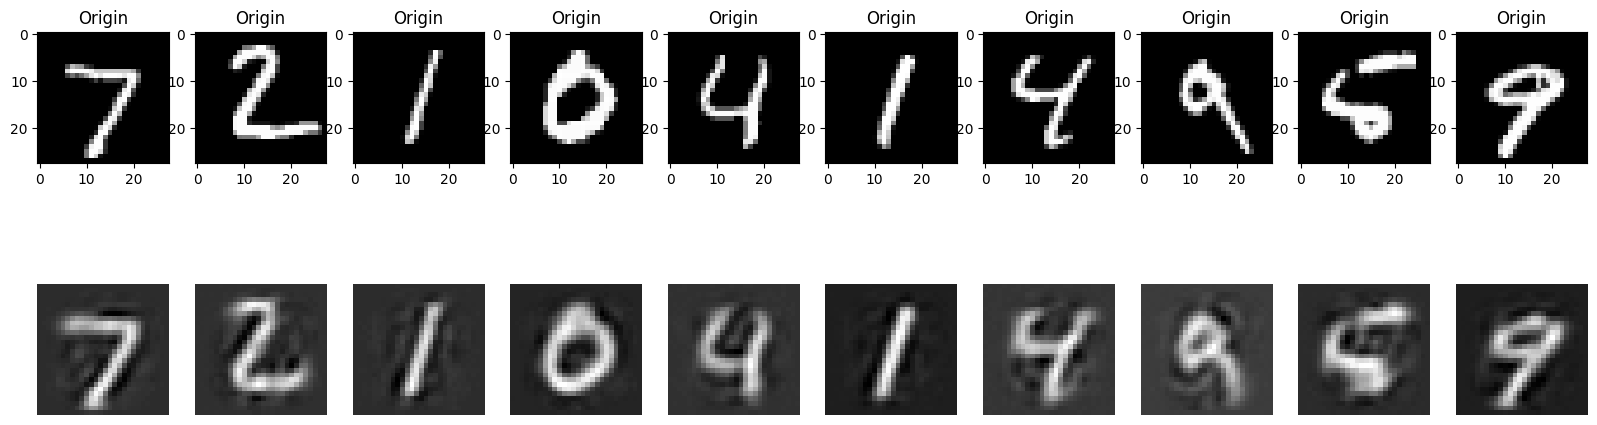

In [7]:
# ÌïôÏäµÎêú Î™®Îç∏ Ï†ÄÏû•ÌïòÏó¨ ÌååÏùºÎ°ú Îã§Ïö¥Î°úÎìúÎ∞õÏïÑÏÑú Í∞ñÍ≥† ÏûàÏñ¥ÏïºÏßÄ gpu ÏïÑÎÇå ÌïôÏäµÏóê 20Î∂Ñ 30Î∂Ñ Ïò§ÎûòÍ±∏Î¶º

# ÎààÏúºÎ°ú ÌôïÏù∏ Í∑∏ÎûòÌîÑ Í∑∏Î¶ºÏúºÎ°ú Î≥¥Í∏∞
import matplotlib.pyplot as plt
import numpy as np# ÌÜ†ÏπòÎ°ú ÎÑòÌååÏù¥ÎÇò ÌïÑÎ°ú ÌòïÌÉú Î≥∏Îã§

# ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞ÏóêÏÑú Ïù¥ÎØ∏ÏßÄ Í∞ÄÏ†∏Ïò§Í∏∞
images, labels = next(iter(testloader))
images_flat = images.view(images.size(0), -1)# 1DÎ°ú ÌéºÏπòÍ∏∞

# Î™®Îç∏Î°ú Ïù¥ÎØ∏ÏßÄ Î≥µÏõê
recon_images_flat, encoded = model(images_flat)
recon_images = recon_images_flat.view(images.size())# Îã§Ïãú 2D Ïù¥ÎØ∏ÏßÄ ÌòïÌÉúÎ°ú

# ÏõêÎ≥∏ vs Î≥µÏõê Ïù¥ÎØ∏ÏßÄ ÎπÑÍµê ÏãúÍ∞ÅÌôî
n_imgs = 10
plt.figure(figsize=(20, 6))
for i in range(n_imgs):
    # ÏõêÎ≥∏ Ïù¥ÎØ∏ÏßÄ ÌëúÏãú
    ax = plt.subplot(2, n_imgs, i+1)
    plt.imshow(np.transpose(images[i].numpy(), (1,2,0)).squeeze(), cmap='gray')#c,h,w -> h,w,c -> h,w
    #(c,h,w):(1,2,0) -> (h,w,c) c Ï±ÑÎÑêÏù¥ ÌïòÎÇòÎãàÍπå ÏûàÏúºÎÇò ÏóÜÏúºÎÇò Í∞ôÏùÄ Í≥µÍ∞ÑÏù¥Îã§ Í∑∏ÎûòÏÑú squeezeÎ°ú cÎ•º ÏóÜÏï∞->(h,w)
    ax.set_title('Origin')

    # Î≥µÏõêÎêú Ïù¥ÎØ∏ÏßÄ ÌëúÏãú
    ax = plt.subplot(2, n_imgs, i+1+n_imgs)
    plt.imshow(np.transpose(recon_images[i].detach().numpy(), (1,2,0)).squeeze(), cmap='gray')

    plt.axis('off')

Î≥µÏõêÎêú Ïù¥ÎØ∏ÏßÄÍ∞Ä ÏõêÎ≥∏Î≥¥Îã§ ÌùêÎ¶øÌïòÍ≤å Î≥¥Ïù¥Îäî Í≤ÉÏùÄ Ïò§ÌÜ†Ïù∏ÏΩîÎçîÏùò ÌäπÏÑ±Í≥º ÌïôÏäµ Í≥ºÏ†ï ÎïåÎ¨∏Ïóê Î∞úÏÉùÌïòÎäî ÏùºÎ∞òÏ†ÅÏù∏ ÌòÑÏÉÅÏûÖÎãàÎã§. Î™á Í∞ÄÏßÄ Ïù¥Ïú†Í∞Ä ÏûàÏäµÎãàÎã§:

1. Ï†ïÎ≥¥ ÏÜêÏã§ (ÏïïÏ∂ï): Ïò§ÌÜ†Ïù∏ÏΩîÎçîÎäî Ïù¥ÎØ∏ÏßÄÎ•º Ïù∏ÏΩîÎçîÎ•º ÌÜµÌï¥ Ïû†Ïû¨ Í≥µÍ∞Ñ(latent space)Ïù¥ÎùºÎäî Îçî ÏûëÏùÄ Ï∞®ÏõêÏúºÎ°ú ÏïïÏ∂ïÌï©ÎãàÎã§. Ïù¥ Í≥ºÏ†ïÏóêÏÑú Ïù¥ÎØ∏ÏßÄÏùò Î™®Îì† ÏÑ∏Î∂Ä Ï†ïÎ≥¥Î•º ÏôÑÎ≤ΩÌïòÍ≤å Î≥¥Ï°¥ÌïòÍ∏∞ Ïñ¥Î†µÏäµÎãàÎã§. ÏïïÏ∂ï Í≥ºÏ†ïÏóêÏÑú ÏùºÎ∂Ä Ï†ïÎ≥¥Í∞Ä ÏÜêÏã§ÎêòÎ©¥ÏÑú Î≥µÏõê Ïãú ÏõêÎ≥∏Í≥º ÏôÑÏ†ÑÌûà ÎèôÏùºÌïòÍ≤å ÎßåÎì§Ïñ¥ÏßÄÏßÄ Î™ªÌïòÍ≥† ÏÑ∏Î∂ÄÏ†ÅÏù∏ Î∂ÄÎ∂ÑÏù¥ ÌùêÎ¶øÌï¥Ïßà Ïàò ÏûàÏäµÎãàÎã§. ÌäπÌûà Dense Î†àÏù¥Ïñ¥Î•º ÏÇ¨Ïö©ÌïòÎäî ÏùºÎ∞òÏ†ÅÏù∏ Ïò§ÌÜ†Ïù∏ÏΩîÎçî(AE)Îäî Ïù¥ÎØ∏ÏßÄÎ•º 1Ï∞®Ïõê Î≤°ÌÑ∞Î°ú ÌéºÏπòÎ©¥ÏÑú Í≥µÍ∞ÑÏ†ÅÏù∏ Ï†ïÎ≥¥ ÏùºÎ∂ÄÎ•º ÏûÉÏùÑ Ïàò ÏûàÏäµÎãàÎã§. CNN Ïò§ÌÜ†Ïù∏ÏΩîÎçî(CNNAE)Îäî ÏÉÅÎåÄÏ†ÅÏúºÎ°ú Í≥µÍ∞Ñ Ï†ïÎ≥¥Î•º Îçî Ïûò Î≥¥Ï°¥ÌïòÏßÄÎßå, ÌíÄÎßÅ(Pooling) Í≥ºÏ†ïÏóêÏÑú Ïó¨Ï†ÑÌûà ÏùºÎ∂Ä Ï†ïÎ≥¥Í∞Ä ÏÜêÏã§Îê©ÎãàÎã§.
2. ÌèâÍ∑†Ìôî Í≤ΩÌñ•: Ïò§ÌÜ†Ïù∏ÏΩîÎçîÎäî ÌõàÎ†® Îç∞Ïù¥ÌÑ∞ÏÖãÏùò Îã§ÏñëÌïú Ïù¥ÎØ∏ÏßÄÎ•º ÌïôÏäµÌïòÏó¨ ÌèâÍ∑†Ï†ÅÏù∏ ÌäπÏßïÏùÑ Ï∂îÏ∂úÌïòÎäî Í≤ΩÌñ•Ïù¥ ÏûàÏäµÎãàÎã§. ÌäπÌûà ÎÖ∏Ïù¥Ï¶à Ï†úÍ±∞ Ïò§ÌÜ†Ïù∏ÏΩîÎçîÏùò Í≤ΩÏö∞, ÎÖ∏Ïù¥Ï¶àÎ•º Ï†úÍ±∞ÌïòÍ≥† Íπ®ÎÅóÌïú Ïù¥ÎØ∏ÏßÄÎ•º Î≥µÏõêÌïòÎäî Í≥ºÏ†ïÏóêÏÑú ÏïΩÍ∞ÑÏùò ÌèâÍ∑†ÌôîÍ∞Ä ÏùºÏñ¥ÎÇò Ïù¥ÎØ∏ÏßÄÏùò ÏÑ†Î™ÖÎèÑÍ∞Ä Îñ®Ïñ¥Ïßà Ïàò ÏûàÏäµÎãàÎã§.
3. ÏÜêÏã§ Ìï®Ïàò (MSELoss): ÌòÑÏû¨ ÏÇ¨Ïö©ÌïòÍ≥† ÏûàÎäî ÏÜêÏã§ Ìï®ÏàòÏù∏ MSELoss(Mean Squared Error)Îäî ÌîΩÏÖÄ Í∞íÏùò ÌèâÍ∑† Ï†úÍ≥± Ïò§Ï∞®Î•º ÏµúÏÜåÌôîÌïòÎäî Î∞©Ìñ•ÏúºÎ°ú ÌïôÏäµÌï©ÎãàÎã§. MSELossÎäî Ïù¥ÎØ∏ÏßÄÏùò Ï†ÑÎ∞òÏ†ÅÏù∏ Íµ¨Ï°∞ÎÇò Î∞ùÍ∏∞ Îì±ÏùÑ Ïûò ÎßûÏ∂îÎäî Îç∞Îäî Ìö®Í≥ºÏ†ÅÏù¥ÏßÄÎßå, Ïù¥ÎØ∏ÏßÄÏùò Í≥†Ï£ºÌåå ÏÑ±Î∂Ñ(Ïó£ÏßÄ, ÎîîÌÖåÏùº)ÏùÑ ÏôÑÎ≤ΩÌïòÍ≤å Î≥µÏõêÌïòÎäî Îç∞Îäî ÌïúÍ≥ÑÍ∞Ä ÏûàÏùÑ Ïàò ÏûàÏäµÎãàÎã§. Ïù¥Îäî Í≤∞Í≥ºÏ†ÅÏúºÎ°ú Ïù¥ÎØ∏ÏßÄÍ∞Ä ÏïΩÍ∞Ñ ÌùêÎ¶øÌï¥ÏßÄÎäî ÏõêÏù∏Ïù¥ Îê† Ïàò ÏûàÏäµÎãàÎã§.
4. Î™®Îç∏ Íµ¨Ï°∞Ïùò ÌïúÍ≥Ñ: ÌòÑÏû¨ Î™®Îç∏Ïùò Î†àÏù¥Ïñ¥ ÏàòÎÇò Ï±ÑÎÑê ÏàòÍ∞Ä Ïù¥ÎØ∏ÏßÄÏùò Î™®Îì† Î≥µÏû°ÏÑ±ÏùÑ ÏôÑÎ≤ΩÌïòÍ≤å ÌïôÏäµÌïòÍ∏∞Ïóê Ï∂©Î∂ÑÌïòÏßÄ ÏïäÏùÑ Ïàò ÏûàÏäµÎãàÎã§. Îçî ÍπäÍ±∞ÎÇò ÎÑìÏùÄ Î™®Îç∏ÏùÑ ÏÇ¨Ïö©ÌïòÎ©¥ Î≥µÏõê ÏÑ±Îä•Ïù¥ Ìñ•ÏÉÅÎê† ÏàòÎèÑ ÏûàÏäµÎãàÎã§.
5. ÌïôÏäµ ÌöüÏàò (Epochs): ÏóêÌè≠ ÏàòÎ•º ÎäòÎ¶¨Î©¥ Î™®Îç∏Ïù¥ Îç∞Ïù¥ÌÑ∞Î•º Îçî ÎßéÏù¥ ÌïôÏäµÌïòÎ©¥ÏÑú Î≥µÏõê ÏÑ±Îä•Ïù¥ Í∞úÏÑ†Îê† Ïàò ÏûàÏäµÎãàÎã§. ÌïòÏßÄÎßå ÎÑàÎ¨¥ ÎßéÏù¥ ÌïôÏäµÌïòÎ©¥ Í≥ºÏ†ÅÌï©(overfitting) Î¨∏Ï†úÍ∞Ä Î∞úÏÉùÌï† ÏàòÎèÑ ÏûàÏäµÎãàÎã§.

CNN Ïò§ÌÜ†Ïù∏ÏΩîÎçî(CNNAE)Ïùò Í≤ΩÏö∞, Dense Ïò§ÌÜ†Ïù∏ÏΩîÎçî(AE)Î≥¥Îã§ Ïù¥ÎØ∏ÏßÄÏùò Í≥µÍ∞ÑÏ†ÅÏù∏ ÌäπÏßïÏùÑ Îçî Ïûò ÌôúÏö©ÌïòÍ∏∞ ÎïåÎ¨∏Ïóê ÏùºÎ∞òÏ†ÅÏúºÎ°ú Î≥µÏõêÎêú Ïù¥ÎØ∏ÏßÄÍ∞Ä Ï¢Ä Îçî ÏÑ†Î™ÖÌïòÍ≤å Î≥¥Ïùº Ïàò ÏûàÏäµÎãàÎã§.

Ïù¥ÎØ∏ÏßÄ Î≥µÏõê ÌíàÏßàÏùÑ Í∞úÏÑ†ÌïòÍ∏∞ ÏúÑÌï¥ÏÑúÎäî Îã§ÏùåÍ≥º Í∞ôÏùÄ Î∞©Î≤ïÎì§ÏùÑ ÏãúÎèÑÌï¥ Î≥º Ïàò ÏûàÏäµÎãàÎã§.

- Î™®Îç∏ Íµ¨Ï°∞ Î≥ÄÍ≤Ω: CNN Ïò§ÌÜ†Ïù∏ÏΩîÎçîÏùò Î†àÏù¥Ïñ¥ ÏàòÎÇò ÌïÑÌÑ∞ ÏàòÎ•º ÎäòÎ¶¨Í±∞ÎÇò, Îã§Î•∏ Ï¢ÖÎ•òÏùò Î†àÏù¥Ïñ¥(Ïòà: Residual block)Î•º ÏÇ¨Ïö©Ìï¥ Î≥º Ïàò ÏûàÏäµÎãàÎã§.
- Îã§Î•∏ ÏÜêÏã§ Ìï®Ïàò ÏÇ¨Ïö©: Ïù¥ÎØ∏ÏßÄ ÌíàÏßà ÌèâÍ∞ÄÏóê Îçî Ï†ÅÌï©Ìïú SSIM (Structural Similarity Index) Í∞ôÏùÄ ÏÜêÏã§ Ìï®ÏàòÎÇò perceptual lossÎ•º ÏÇ¨Ïö©Ìï¥ Î≥º Ïàò ÏûàÏäµÎãàÎã§.
- Îçî ÎßéÏùÄ ÌïôÏäµ Îç∞Ïù¥ÌÑ∞ ÎòêÎäî ÏóêÌè≠ ÏÇ¨Ïö©: Î™®Îç∏Ïù¥ Îçî Îã§ÏñëÌïú Ïù¥ÎØ∏ÏßÄÎ•º Î≥¥Í≥† ÌïôÏäµÌï† Í∏∞ÌöåÎ•º ÎäòÎ¶ΩÎãàÎã§.
- ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞ ÌäúÎãù: ÌïôÏäµÎ•†(learning rate)Ïù¥ÎÇò Î∞∞Ïπò ÌÅ¨Í∏∞ Îì±ÏùÑ Ï°∞Ï†ïÌï¥ Î≥º Ïàò ÏûàÏäµÎãàÎã§.
ÌòÑÏû¨ Î≥µÏõêÎêú Ïù¥ÎØ∏ÏßÄÎäî ÏõêÎ≥∏ Ïù¥ÎØ∏ÏßÄÏùò ÌòïÌÉúÎ•º Ïûò ÌååÏïÖÌï† Ïàò ÏûàÎäî ÏàòÏ§ÄÏù¥ÎØÄÎ°ú, Ïò§ÌÜ†Ïù∏ÏΩîÎçîÍ∞Ä Ïù¥ÎØ∏ÏßÄÏùò Ï£ºÏöî ÌäπÏßïÏùÑ Ïûò ÌïôÏäµÌñàÎã§Í≥† Î≥º Ïàò ÏûàÏäµÎãàÎã§.

In [8]:
print(images.size())
print(recon_images_flat.size())
print(recon_images.size())
print(images[0].numpy().shape)

torch.Size([64, 1, 28, 28])
torch.Size([64, 784])
torch.Size([64, 1, 28, 28])
(1, 28, 28)


torch.Size([64, 32])


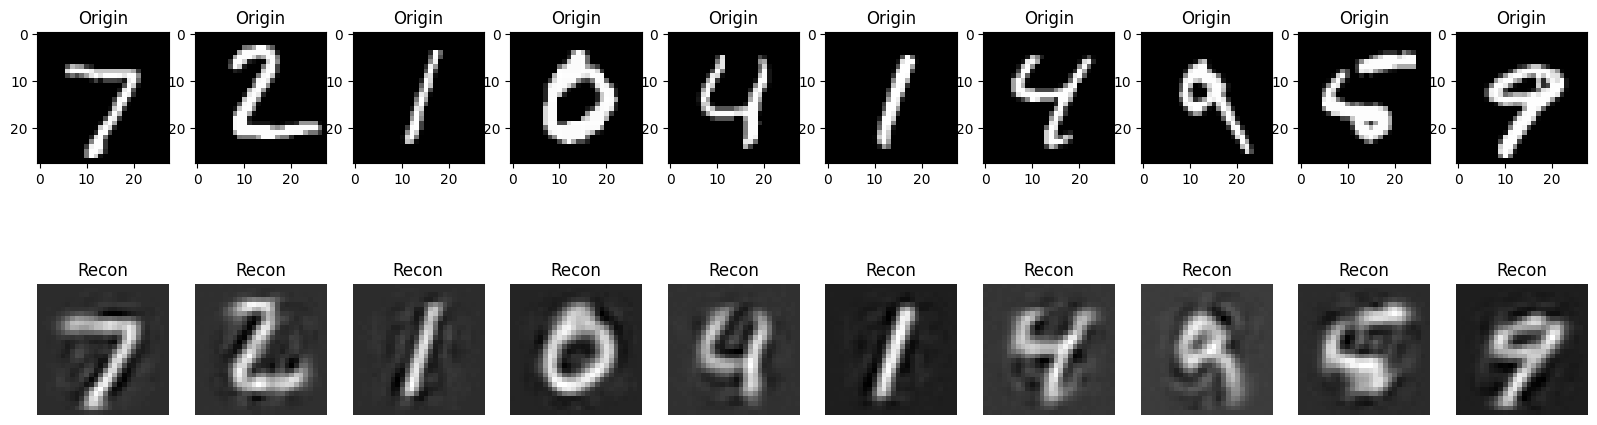

In [9]:
images, labels = next(iter(testloader))
images_flat = images.view(images.size(0), -1)

# recon_images_flat, encoded = model(images_flat)
encoded2 = model.encoder(images_flat)# Ïò§ÌÜ†Ïù∏ÏΩîÎçî Î™®Îç∏Ïùò Ïù∏ÏΩîÎçî Î∂ÄÎ∂ÑÎßå Ïã§ÌñâÌïòÏó¨ ÏõêÎ≥∏ Ïù¥ÎØ∏ÏßÄ(images_flat)Î•º Ïû†Ïû¨ Í≥µÍ∞Ñ ÌëúÌòÑ(encoded2)ÏúºÎ°ú ÏïïÏ∂ïÌïòÎäî Îã®Í≥ÑÏûÖÎãàÎã§.
print(encoded2.shape)#Ïù¥ ÌòïÌÉúÎäî Ïû†Ïû¨ Í≥µÍ∞ÑÏùò ÌÅ¨Í∏∞Î•º Î≥¥Ïó¨Ï§çÎãàÎã§ (Ïòà: torch.Size([64, 32])Îäî Î∞∞Ïπò ÌÅ¨Í∏∞ 64Ïóê Í∞Å Ïù¥ÎØ∏ÏßÄÏùò ÌäπÏßïÏù¥ 32Ï∞®Ïõê Î≤°ÌÑ∞Î°ú ÌëúÌòÑÎêòÏóàÏùåÏùÑ ÏùòÎØ∏Ìï©ÎãàÎã§).

recon_images_flat = model.decoder(encoded2)#model.decoder(encoded2)Î•º ÏßÅÏ†ë Ìò∏Ï∂úÌï©ÎãàÎã§. Ïù¥Îäî Ïò§ÌÜ†Ïù∏ÏΩîÎçî Î™®Îç∏Ïùò ÎîîÏΩîÎçî Î∂ÄÎ∂ÑÎßå Ïã§ÌñâÌïòÏó¨ Ïù∏ÏΩîÎî©Îêú ÌäπÏßï(encoded2)ÏùÑ ÏûÖÎ†•ÏúºÎ°ú Î∞õÏïÑ Î≥µÏõêÎêú Ïù¥ÎØ∏ÏßÄ(recon_images_flat)Î•º ÏÉùÏÑ±ÌïòÎäî Îã®Í≥ÑÏûÖÎãàÎã§.
recon_images = recon_images_flat.view(images.size())

n_imgs = 10
plt.figure(figsize=(20, 6))
for i in range(n_imgs):
    ax = plt.subplot(2, n_imgs, i+1)
    plt.imshow(np.transpose(images[i].numpy(), (1,2,0)).squeeze(), cmap='gray')#c,h,w -> h,w,c -> h,w
    #(c,h,w):(1,2,0) -> (h,w,c) c Ï±ÑÎÑêÏù¥ ÌïòÎÇòÎãàÍπå ÏûàÏúºÎÇò ÏóÜÏúºÎÇò Í∞ôÏùÄ Í≥µÍ∞ÑÏù¥Îã§ Í∑∏ÎûòÏÑú squeezeÎ°ú cÎ•º ÏóÜÏï∞->(h,w)
    ax.set_title('Origin')

    ax = plt.subplot(2, n_imgs, i+1+n_imgs)
    plt.imshow(np.transpose(recon_images[i].detach().numpy(), (1,2,0)).squeeze(), cmap='gray')
    ax.set_title('Recon')
    plt.axis('off')

plt.show()

In [10]:
encoded.shape

torch.Size([64, 32])

# 4.CNN Ïò§ÌÜ†Ïù∏ÏΩîÎçî ÌÅ¥ÎûòÏä§ (CNNAE)

In [11]:
# CNNÏùÑ ÏÇ¨Ïö©Ìïú Ïò§ÌÜ†Ïù∏ÏΩîÎçî
class CNNAE(nn.Module):
    def __init__(self):
        super(CNNAE, self).__init__()
        # Encoder: Ìï©ÏÑ±Í≥± + ÌíÄÎßÅÏúºÎ°ú ÏïïÏ∂ï
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),    # 1Ï±ÑÎÑê‚Üí16Ï±ÑÎÑê, ÌÅ¨Í∏∞Ïú†ÏßÄ
            nn.ReLU(),
            # Í∞ÄÎ°úÏÑ∏Î°ú Î∞òÎ∞òÏî© ÏÇ¨Ïù¥Ï¶à Ï§ÑÏûÑ
            nn.MaxPool2d(kernel_size=2, stride=2),         # 28x28 ‚Üí 14x14Î°ú ÌÅ¨Í∏∞ Ï†àÎ∞ò
            nn.Conv2d(16, 32, kernel_size=3, padding=1),   # 16Ï±ÑÎÑê‚Üí32Ï±ÑÎÑê
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),         # 14x14 ‚Üí 7x7Î°ú ÌÅ¨Í∏∞ Ï†àÎ∞ò
        )
        # Decoder: Ï†ÑÏπò Ìï©ÏÑ±Í≥±ÏúºÎ°ú Î≥µÏõê
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32,16,kernel_size=2,stride=2),# 32Ï±ÑÎÑê 16Ï±ÑÎÑêÎ°ú ? ÏÇ¨Ïù¥Ï¶à ÌÇ§Ïö∞Í∏∞?? # 7x7 ‚Üí 14x14Î°ú ÌÅ¨Í∏∞ 2Î∞∞
            nn.ReLU(),
            nn.ConvTranspose2d(16,1,kernel_size=2,stride=2),# ÎëêÎ∞∞Î°ú ÌÇ§ÏõÄ ??# 14x14 ‚Üí 28x28Î°ú ÌÅ¨Í∏∞ 2Î∞∞
            nn.Sigmoid()# 0~1ÏÇ¨Ïù¥ Í∞íÏúºÎ°ú Îß§Ìïë# 0~1 Î≤îÏúÑÎ°ú Ï∂úÎ†•Í∞í Ï†úÌïú (Ïù¥ÎØ∏ÏßÄ ÌîΩÏÖÄ Í∞í)
            )

    def forward(self, x): # Ïù¥ÎØ∏ÏßÄ ÏßëÏñ¥ÎÑ£ÏúºÎ©¥ ÎèÑÎäîÍ±∞
        encoded = self.encoder(x)    # Ïù¥ÎØ∏ÏßÄ ÏïïÏ∂ï
        decoded = self.decoder(encoded)  # Ïù¥ÎØ∏ÏßÄ Î≥µÏõê
        return decoded, encoded

## Î™®Îç∏ ÏÉùÏÑ± Î∞è ÏÑ§Ï†ï

In [12]:
# model1=CNNAE() # CNN Ïò§ÌÜ†Ïù∏ÏΩîÎçî ÏÇ¨Ïö©
model1=CNNAE().to(device) # CNN Ïò§ÌÜ†Ïù∏ÏΩîÎçî ÏÇ¨Ïö©
print(model1) # Î™®Îç∏ Íµ¨Ï°∞ Ï∂úÎ†•

CNNAE(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(2, 2), stride=(2, 2))
    (1): ReLU()
    (2): ConvTranspose2d(16, 1, kernel_size=(2, 2), stride=(2, 2))
    (3): Sigmoid()
  )
)


## Î™®Îç∏ ÌïôÏäµ

In [13]:
loss_fn = nn.MSELoss()# ÌèâÍ∑†Ï†úÍ≥±Ïò§Ï∞® (ÏõêÎ≥∏Í≥º Î≥µÏõê Ïù¥ÎØ∏ÏßÄÏùò Ï∞®Ïù¥)
optim = opt.Adam(model1.parameters(), lr=0.001)# Adam ÏµúÏ†ÅÌôî

# Training
epochs = 10 # Ï†ÑÏ≤¥ Îç∞Ïù¥ÌÑ∞Í∞Ä ÌïúÎ≤à Îã§ ÌïôÏäµÌïòÎäî Í≥ºÏ†ï

for epoch in range(epochs): # ÏóêÌè≠
    for data in trainloader: # Ïä§ÌÉù
        inputs,  _ = data # Ïò§ÌÜ†Ïù∏ÏΩîÎçîÎäî ÎùºÎ≤®Ïù¥ ÌïÑÏöîÌïòÏßÄ ÏïäÏïÑÏÑú _Î°ú ÌëúÌòÑ
        inputs = inputs.to(device)

        optim.zero_grad()# Í∏∞Ïö∏Í∏∞ Ï¥àÍ∏∞Ìôî
        outputs, _ = model1(inputs)# Î≥µÏõêÎêú Ïù¥ÎØ∏ÏßÄ ÏÉùÏÑ±
        loss = loss_fn(outputs, inputs)# ÏõêÎ≥∏Í≥º Î≥µÏõê Ïù¥ÎØ∏ÏßÄ ÎπÑÍµê

        loss.backward()# Ïó≠Ï†ÑÌåå
        optim.step()# Í∞ÄÏ§ëÏπò ÏóÖÎç∞Ïù¥Ìä∏

    print(f"epoch : {epoch}, loss : {loss}")

print("finish")

epoch : 0, loss : 0.004532213322818279
epoch : 1, loss : 0.003216513665392995
epoch : 2, loss : 0.0026650705840438604
epoch : 3, loss : 0.0025625182315707207
epoch : 4, loss : 0.0027914773672819138
epoch : 5, loss : 0.002181776100769639
epoch : 6, loss : 0.0025016642175614834
epoch : 7, loss : 0.0022099458146840334
epoch : 8, loss : 0.001986744347959757
epoch : 9, loss : 0.001982497051358223
finish


## Í≤∞Í≥º ÏãúÍ∞ÅÌôî

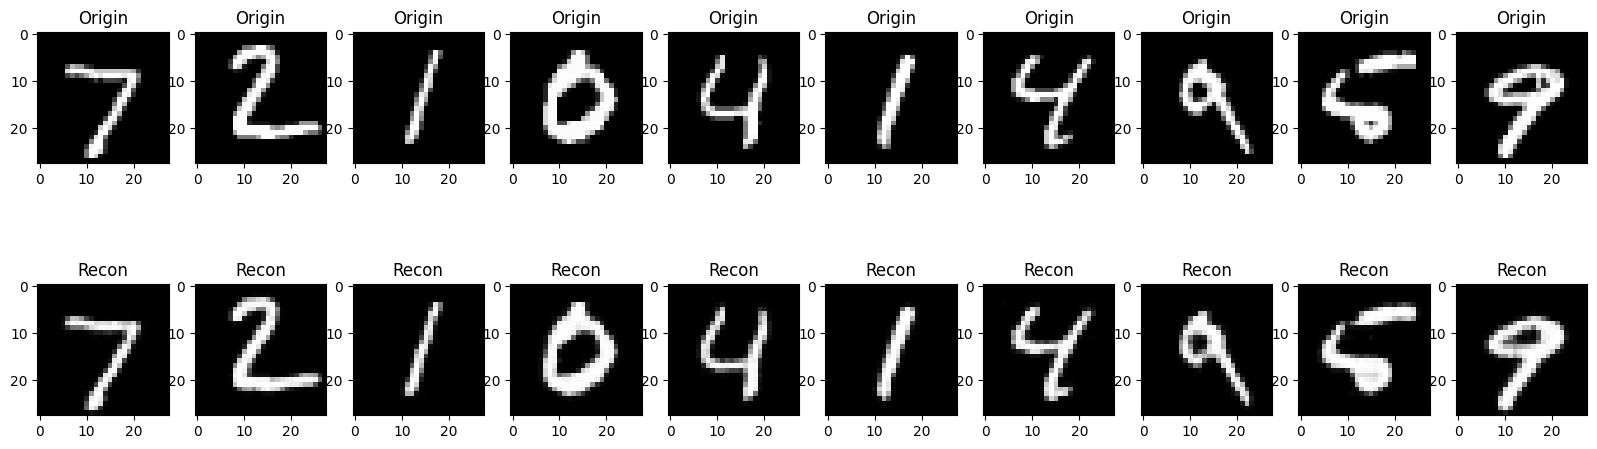

In [14]:
images, labels = next(iter(testloader))
# üîÑ Ï†ÑÏ≤¥ Ïò§ÌÜ†Ïù∏ÏΩîÎçîÎ•º Ìïú Î≤àÏóê Ïã§Ìñâ- forward() Î©îÏÑúÎìú Ìò∏Ï∂ú
recon_images_flat, encoded = model1(images) #CNN Ïò§ÌÜ†Ïù∏ÏΩîÎçîÍ∞Ä Ïù¥ÎØ∏ÏßÄÎ•º ÏïïÏ∂ï ‚Üí Î≥µÏõê
# recon_images_flat: Î≥µÏõêÎêú Ïù¥ÎØ∏ÏßÄ (ÌèâÎ©¥ÌôîÎêú ÏÉÅÌÉú)
# recon_images: ÏõêÎ≥∏Í≥º Í∞ôÏùÄ ÌÅ¨Í∏∞Î°ú Î≥ÄÌòï (100, 1, 28, 28)
recon_images = recon_images_flat.view(images.size())

n_imgs = 10
plt.figure(figsize=(20, 6))
for i in range(n_imgs):
    ax = plt.subplot(2, n_imgs, i+1)
    plt.imshow(np.transpose(images[i].numpy(), (1,2,0)).squeeze(), cmap='gray')#c,h,w -> h,w,c -> h,w
    #(c,h,w):(1,2,0) -> (h,w,c) c Ï±ÑÎÑêÏù¥ ÌïòÎÇòÎãàÍπå ÏûàÏúºÎÇò ÏóÜÏúºÎÇò Í∞ôÏùÄ Í≥µÍ∞ÑÏù¥Îã§ Í∑∏ÎûòÏÑú squeezeÎ°ú cÎ•º ÏóÜÏï∞->(h,w)
    ax.set_title('Origin')

    ax = plt.subplot(2, n_imgs, i+1+n_imgs)
    plt.imshow(np.transpose(recon_images[i].detach().cpu().numpy(), (1,2,0)).squeeze(), cmap='gray')
    ax.set_title('Recon')

plt.show()

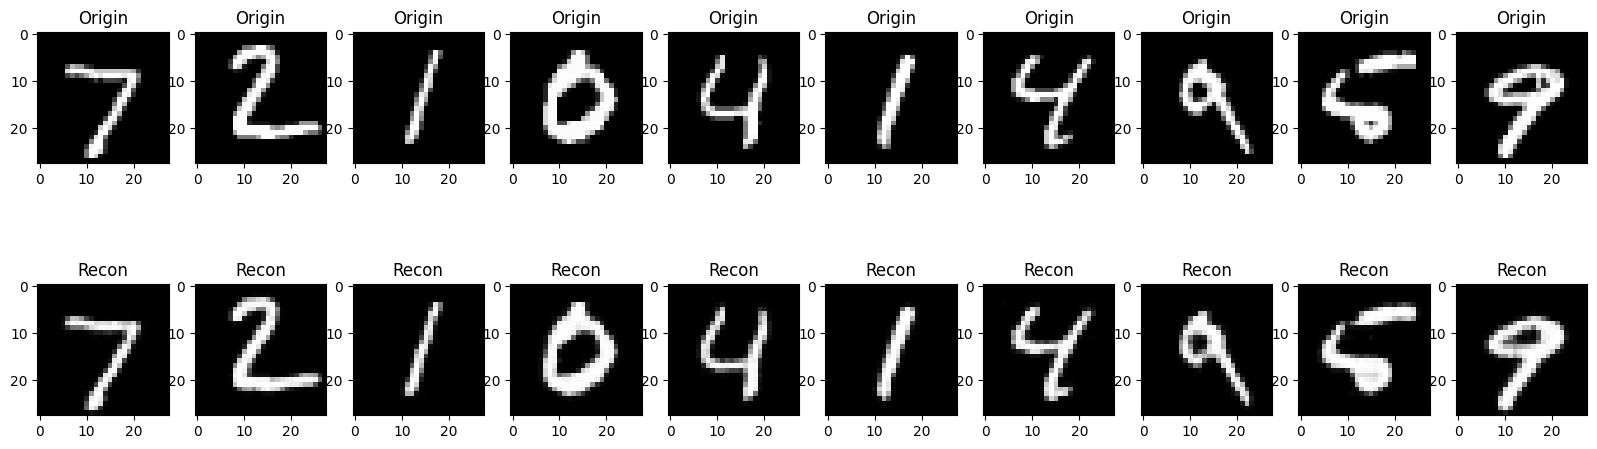

In [15]:
images, labels = next(iter(testloader))
# images_flat = images.view(images.size(0), -1) # CNN Ïù¥ÎùºÏÑú ÏïàÏç®ÎèÑ ÎêúÎã§.
# üîÄ Ïù∏ÏΩîÎçîÏôÄ ÎîîÏΩîÎçîÎ•º Î∂ÑÎ¶¨Ìï¥ÏÑú Ïã§Ìñâ
encoded2 = model1.encoder(images.to(device))     # 1Îã®Í≥Ñ: Ïù∏ÏΩîÎçîÎßå Ïã§Ìñâ
recon_images_flat = model1.decoder(encoded2)     # 2Îã®Í≥Ñ: ÎîîÏΩîÎçîÎßå Ïã§Ìñâ

# recon_images_flat, encoded = model1(images_flat)
recon_images = recon_images_flat.view(images.size())

n_imgs = 10
plt.figure(figsize=(20, 6))
for i in range(n_imgs):
    ax = plt.subplot(2, n_imgs, i+1)
    #c,h,w -> h,w,c -> h,w
    plt.imshow(np.transpose(images[i].numpy(), (1,2,0)).squeeze(), cmap='gray')
    #(c,h,w):(1,2,0) -> (h,w,c) c Ï±ÑÎÑêÏù¥ ÌïòÎÇòÎãàÍπå ÏûàÏúºÎÇò ÏóÜÏúºÎÇò Í∞ôÏùÄ Í≥µÍ∞ÑÏù¥Îã§ Í∑∏ÎûòÏÑú squeezeÎ°ú cÎ•º ÏóÜÏï∞->(h,w)
    ax.set_title('Origin')

    ax = plt.subplot(2, n_imgs, i+1+n_imgs)
    plt.imshow(np.transpose(recon_images[i].detach().cpu().numpy(), (1,2,0)).squeeze(), cmap='gray')
    ax.set_title('Recon')

plt.show()

In [16]:
print(images.size())
print(recon_images.size())

print(images[0].numpy().shape)
# (c,h,w):(1,2,0) -> (h, w, c) --> h, w

torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
(1, 28, 28)


In [17]:
encoded.shape

torch.Size([64, 32, 7, 7])

---

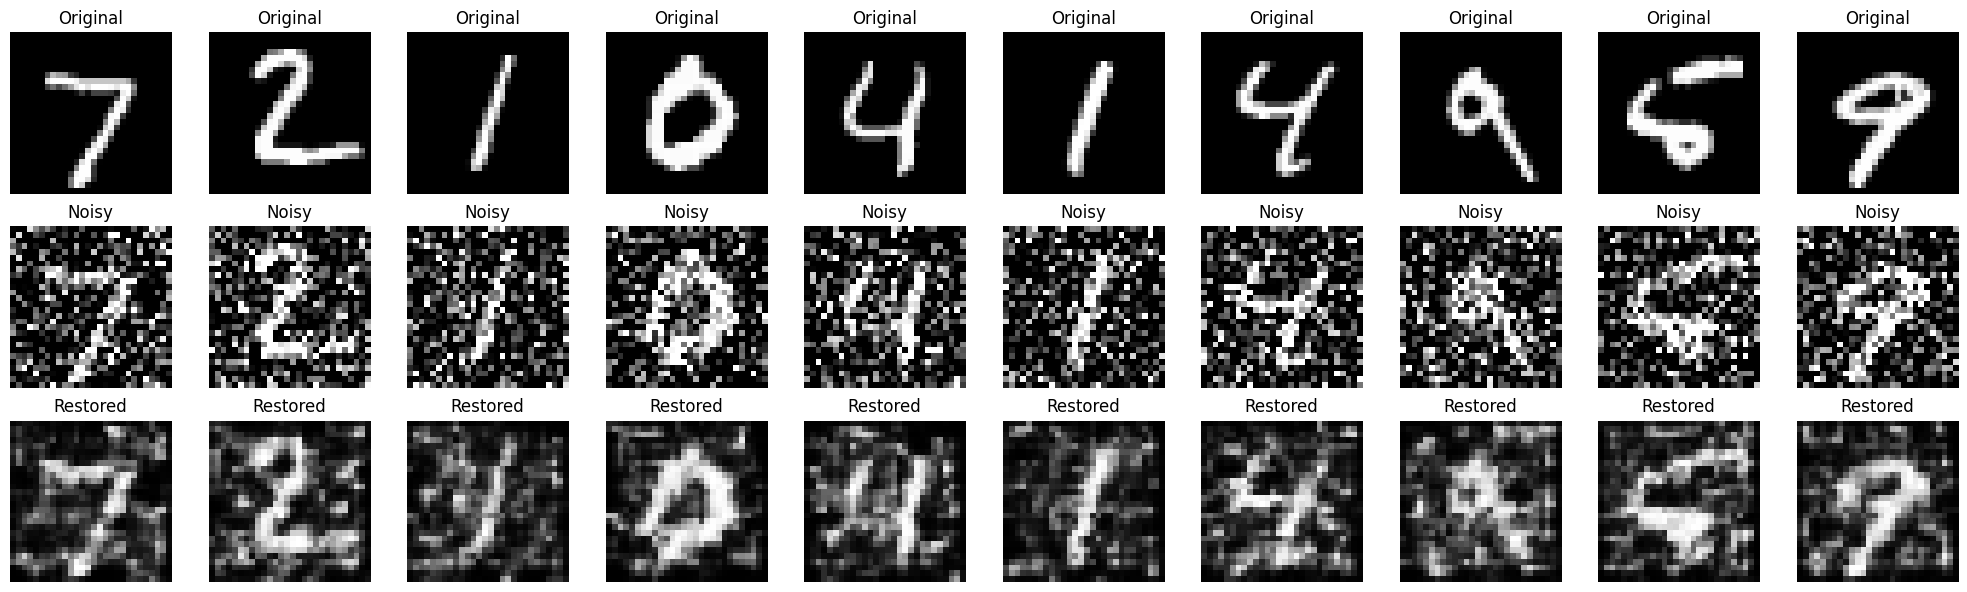

In [18]:
# Í∞ÑÎã® Î≤ÑÏ†Ñ - Í∞ÄÏö∞ÏãúÏïà ÎÖ∏Ïù¥Ï¶àÎßå ÌÖåÏä§Ìä∏
images, labels = next(iter(testloader))
images = images[:10].to(device)

# ÎÖ∏Ïù¥Ï¶à Ï∂îÍ∞Ä
noise_factor = 0.5
noisy_images = images + noise_factor * torch.randn_like(images)
noisy_images = torch.clip(noisy_images, 0, 1)

# Î≥µÏõê
model1.eval()
with torch.no_grad():
    restored_images, _ = model1(noisy_images)

# ÏãúÍ∞ÅÌôî
plt.figure(figsize=(20, 6))
for i in range(10):
    # ÏõêÎ≥∏
    plt.subplot(3, 10, i+1)
    plt.imshow(images[i].cpu().squeeze().numpy(), cmap='gray')
    plt.title('Original')
    plt.axis('off')

    # ÎÖ∏Ïù¥Ï¶à
    plt.subplot(3, 10, i+11)
    plt.imshow(noisy_images[i].cpu().squeeze().numpy(), cmap='gray')
    plt.title('Noisy')
    plt.axis('off')

    # Î≥µÏõê
    plt.subplot(3, 10, i+21)
    plt.imshow(restored_images[i].cpu().squeeze().numpy(), cmap='gray')
    plt.title('Restored')
    plt.axis('off')

plt.tight_layout()
plt.show()


In [19]:
def add_gaussian_noise(images, noise_factor=0.3):
    """Í∞ÄÏö∞ÏãúÏïà ÎÖ∏Ïù¥Ï¶à Ï∂îÍ∞Ä (TV ÌôîÎ©¥ ÏßÄÏßÅÍ±∞Î¶º Í∞ôÏùÄ Ìö®Í≥º)"""
    noisy = images + noise_factor * torch.randn_like(images)  # ÎûúÎç§ ÎÖ∏Ïù¥Ï¶à Ï∂îÍ∞Ä
    return torch.clip(noisy, 0, 1)  # ÌîΩÏÖÄÍ∞íÏùÑ 0~1 Î≤îÏúÑÎ°ú Ï†úÌïú

def add_salt_pepper_noise(images, noise_ratio=0.1):
    """ÏÜåÍ∏àÌõÑÏ∂î ÎÖ∏Ïù¥Ï¶à (Ï†êÎì§Ïù¥ Ï∞çÌûå Í≤ÉÏ≤òÎüº)"""
    noisy = images.clone()
    mask = torch.rand_like(images) < noise_ratio  # ÎûúÎç§ÌïòÍ≤å ÌîΩÏÖÄ ÏÑ†ÌÉù
    noisy[mask] = torch.rand_like(noisy[mask])    # ÏÑ†ÌÉùÎêú ÌîΩÏÖÄÏùÑ ÎûúÎç§Í∞íÏúºÎ°ú ÍµêÏ≤¥
    return noisy

def add_masking_noise(images, mask_ratio=0.3):
    """ÎßàÏä§ÌÇπ (Î∂ÄÎ∂ÑÏ†ÅÏúºÎ°ú Í∞ÄÎ¶¨Í∏∞ - ÎÇôÏÑú Ï†úÍ±∞ÏôÄ Ïú†ÏÇ¨)"""
    noisy = images.clone()
    mask = torch.rand_like(images) < mask_ratio  # ÎûúÎç§ÌïòÍ≤å ÏòÅÏó≠ ÏÑ†ÌÉù
    noisy[mask] = 0  # ÏÑ†ÌÉùÎêú ÏòÅÏó≠ÏùÑ Í≤ÄÏùÄÏÉâÏúºÎ°ú ÎßàÏä§ÌÇπ
    return noisy


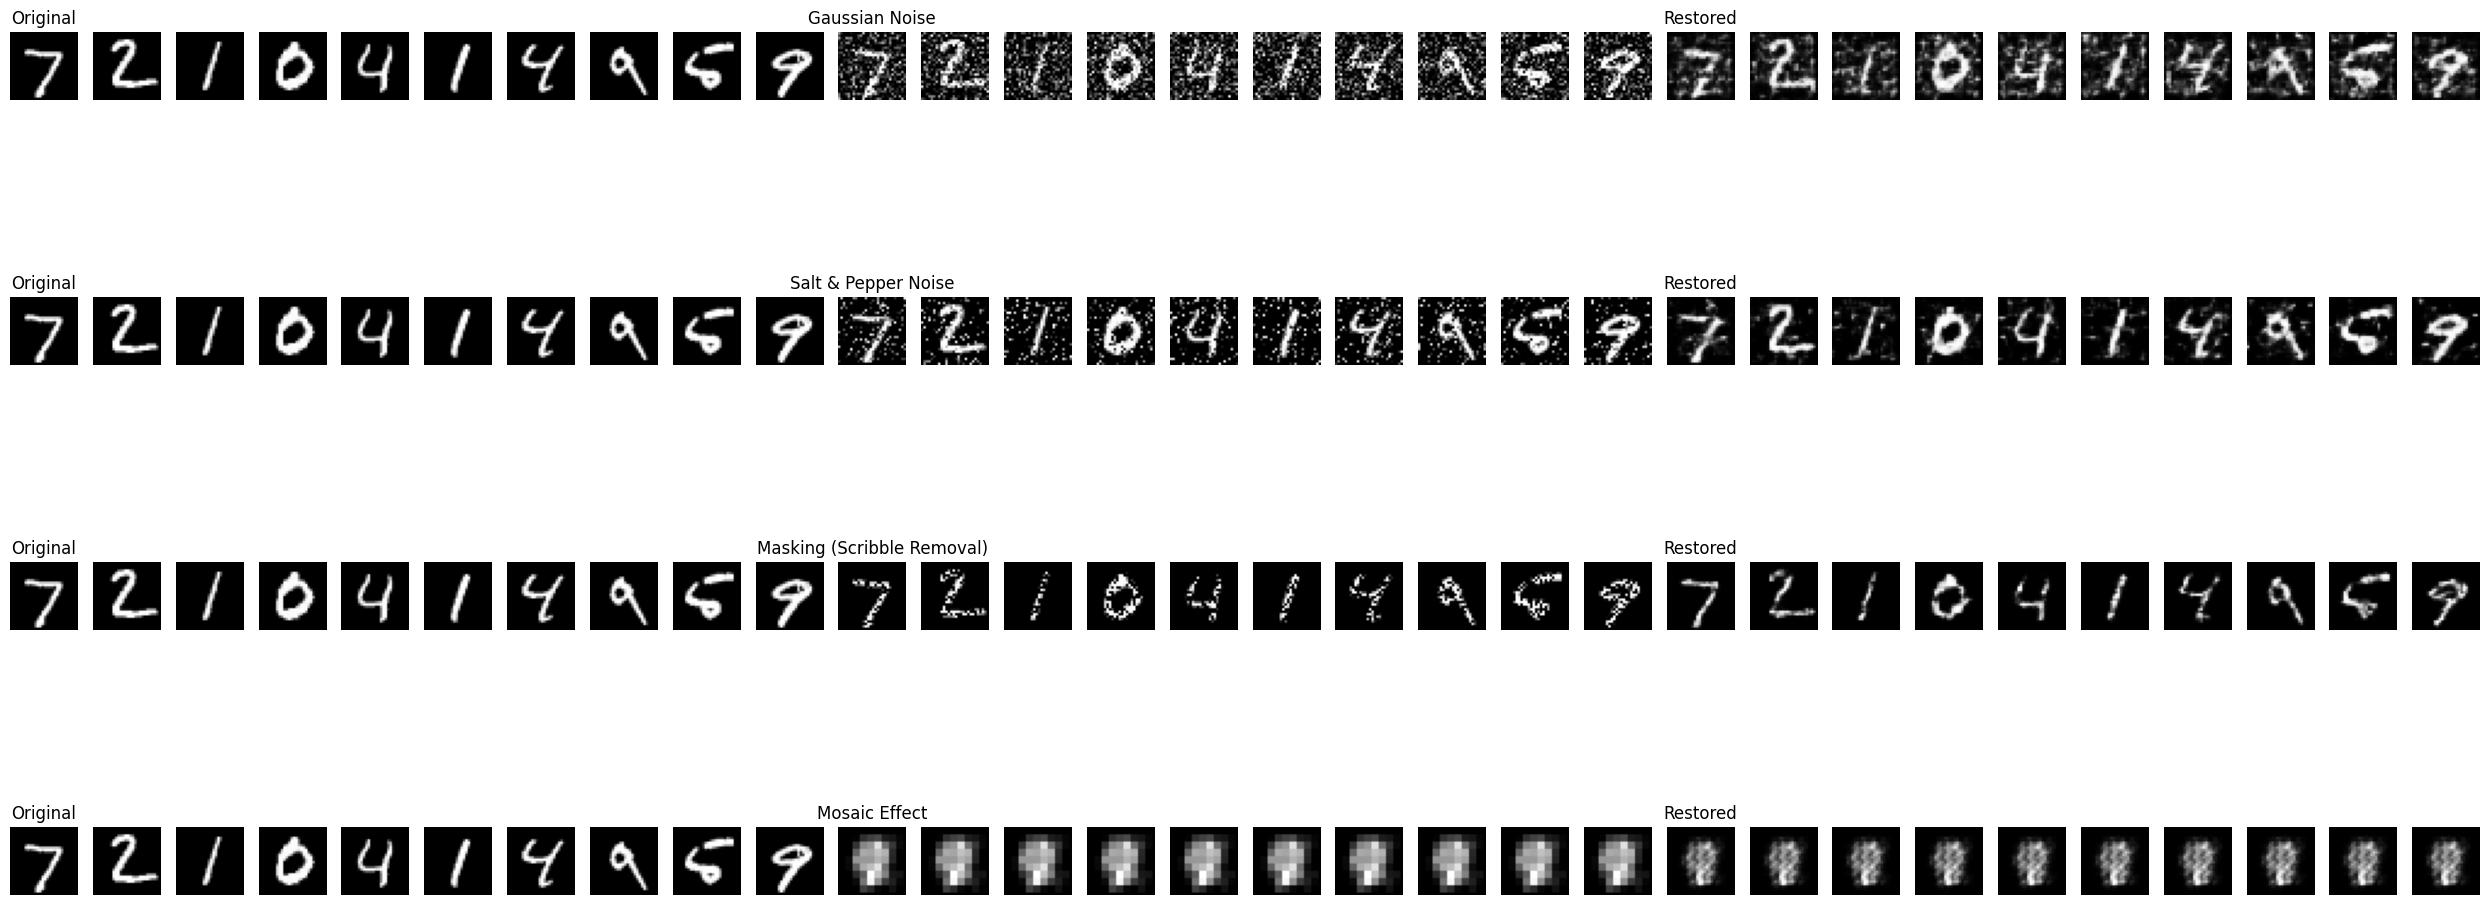

In [20]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# 1. Îã§ÏñëÌïú ÎÖ∏Ïù¥Ï¶à Ï∂îÍ∞Ä Ìï®ÏàòÎì§
def add_gaussian_noise(images, noise_factor=0.3):
    """Í∞ÄÏö∞ÏãúÏïà ÎÖ∏Ïù¥Ï¶à Ï∂îÍ∞Ä (TV ÌôîÎ©¥ ÏßÄÏßÅÍ±∞Î¶º Í∞ôÏùÄ)"""
    noisy = images + noise_factor * torch.randn_like(images)
    return torch.clip(noisy, 0, 1)  # 0~1 Î≤îÏúÑÎ°ú Ï†úÌïú

def add_salt_pepper_noise(images, noise_ratio=0.1):
    """ÏÜåÍ∏àÌõÑÏ∂î ÎÖ∏Ïù¥Ï¶à (Ï†êÎì§Ïù¥ Ï∞çÌûå Í≤ÉÏ≤òÎüº)"""
    noisy = images.clone()
    mask = torch.rand_like(images) < noise_ratio
    noisy[mask] = torch.rand_like(noisy[mask])  # ÎûúÎç§ Í∞íÏúºÎ°ú ÎåÄÏ≤¥
    return noisy

def add_masking_noise(images, mask_ratio=0.3):
    """ÎßàÏä§ÌÇπ (Î∂ÄÎ∂ÑÏ†ÅÏúºÎ°ú Í∞ÄÎ¶¨Í∏∞ - ÎÇôÏÑú Ï†úÍ±∞ÏôÄ Ïú†ÏÇ¨)"""
    noisy = images.clone()
    mask = torch.rand_like(images) < mask_ratio
    noisy[mask] = 0  # Í≤ÄÏùÄÏÉâÏúºÎ°ú ÎßàÏä§ÌÇπ
    return noisy

def add_mosaic_effect(images, block_size=4):
    """Î™®ÏûêÏù¥ÌÅ¨ Ìö®Í≥º (Ï†ÄÌôîÏßà ÎßåÎì§Í∏∞)"""
    noisy = images.clone()
    h, w = images.shape[-2:]

    for i in range(0, h, block_size):
        for j in range(0, w, block_size):
            # Í∞Å Î∏îÎ°ùÏùò ÌèâÍ∑†Í∞íÏúºÎ°ú Ï±ÑÏö∞Í∏∞
            block = noisy[:, :, i:i+block_size, j:j+block_size]
            if block.numel() > 0:
                avg_val = block.mean()
                noisy[:, :, i:i+block_size, j:j+block_size] = avg_val

    return noisy

# 2. ÎÖ∏Ïù¥Ï¶à Ï†úÍ±∞ ÌÖåÏä§Ìä∏
def test_denoising(model, test_images, noise_type='gaussian'):
    """Îã§ÏñëÌïú ÎÖ∏Ïù¥Ï¶àÎ°ú Ïò§ÌÜ†Ïù∏ÏΩîÎçî ÌÖåÏä§Ìä∏"""
    model.eval()

    # ÎÖ∏Ïù¥Ï¶à Ï∂îÍ∞Ä
    if noise_type == 'gaussian':
        noisy_images = add_gaussian_noise(test_images, 0.4)
        title = 'Gaussian Noise'
    elif noise_type == 'salt_pepper':
        noisy_images = add_salt_pepper_noise(test_images, 0.15)
        title = 'Salt & Pepper Noise'
    elif noise_type == 'masking':
        noisy_images = add_masking_noise(test_images, 0.4)
        title = 'Masking (Scribble Removal)'
    elif noise_type == 'mosaic':
        noisy_images = add_mosaic_effect(test_images, 3)
        title = 'Mosaic Effect'

    # Î™®Îç∏Î°ú Î≥µÏõê
    with torch.no_grad():
        noisy_images = noisy_images.to(device)
        restored_images, _ = model(noisy_images)

    return noisy_images.cpu(), restored_images.cpu(), title

# 3. Ïã§Ï†ú ÌÖåÏä§Ìä∏ Ïã§Ìñâ
images, labels = next(iter(testloader))
images = images[:10]  # 10Í∞úÎßå ÏÇ¨Ïö©

# Ïó¨Îü¨ ÎÖ∏Ïù¥Ï¶à ÌÉÄÏûÖÏúºÎ°ú ÌÖåÏä§Ìä∏
noise_types = ['gaussian', 'salt_pepper', 'masking', 'mosaic']

fig, axes = plt.subplots(len(noise_types), 30, figsize=(25, 12))

for noise_idx, noise_type in enumerate(noise_types):
    # ÎÖ∏Ïù¥Ï¶à Ï∂îÍ∞Ä Î∞è Î≥µÏõê
    noisy_imgs, restored_imgs, title = test_denoising(model1, images, noise_type)

    # Ï≤´ 10Í∞ú Ïù¥ÎØ∏ÏßÄÎßå ÏãúÍ∞ÅÌôî
    for i in range(10):
        # ÏõêÎ≥∏
        axes[noise_idx, i].imshow(images[i].squeeze().numpy(), cmap='gray')
        axes[noise_idx, i].set_title('Original' if i == 0 else '')
        axes[noise_idx, i].axis('off')

        # ÎÖ∏Ïù¥Ï¶à ÏûàÎäî Ïù¥ÎØ∏ÏßÄ
        axes[noise_idx, i+10].imshow(noisy_imgs[i].squeeze().numpy(), cmap='gray')
        axes[noise_idx, i+10].set_title(f'{title}' if i == 0 else '')
        axes[noise_idx, i+10].axis('off')

        # Î≥µÏõêÎêú Ïù¥ÎØ∏ÏßÄ
        axes[noise_idx, i+20].imshow(restored_imgs[i].squeeze().numpy(), cmap='gray')
        axes[noise_idx, i+20].set_title('Restored' if i == 0 else '')
        axes[noise_idx, i+20].axis('off')

plt.tight_layout()
plt.show()


In [21]:
model2=CNNAE().to(device) # CNN Ïò§ÌÜ†Ïù∏ÏΩîÎçî ÏÇ¨Ïö©
print(model2) # Î™®Îç∏ Íµ¨Ï°∞ Ï∂úÎ†•

# Denoising AutoEncoder ÌïôÏäµ Î∞©Ïãù
for epoch in range(epochs):
    for data in trainloader:
        clean_images, _ = data
        clean_images = clean_images.to(device)

        # ÌïôÏäµ ÏãúÏóê ÎÖ∏Ïù¥Ï¶à Ï∂îÍ∞Ä!
        noisy_images = add_gaussian_noise(clean_images, 0.3)

        optim.zero_grad()
        outputs, _ = model2(noisy_images)  # ÎÖ∏Ïù¥Ï¶à ÏûÖÎ†•
        loss = loss_fn(outputs, clean_images)  # Íπ®ÎÅóÌïú Ïù¥ÎØ∏ÏßÄÏôÄ ÎπÑÍµê!
        loss.backward()
        optim.step()

CNNAE(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(2, 2), stride=(2, 2))
    (1): ReLU()
    (2): ConvTranspose2d(16, 1, kernel_size=(2, 2), stride=(2, 2))
    (3): Sigmoid()
  )
)


In [22]:
# Î™®Îç∏ Ï†ÄÏû•
model_save_path = 'autoencoder_cnn.pth'
torch.save(model1.state_dict(), model_save_path)
print(f"Î™®Îç∏Ïù¥ {model_save_path}Ïóê Ï†ÄÏû•ÎêòÏóàÏäµÎãàÎã§.")

# Ï†ÄÏû•Îêú Î™®Îç∏ Î∂àÎü¨Ïò§Í∏∞ (ÏÉàÎ°úÏö¥ Î™®Îç∏ Ïù∏Ïä§ÌÑ¥Ïä§Î•º ÏÉùÏÑ±Ìïú ÌõÑ state_dictÎ•º Î°úÎìúÌï©ÎãàÎã§.)
# model1_loaded = CNNAE().to(device) # ÎßåÏïΩ GPUÎ•º ÏÇ¨Ïö©ÌñàÎã§Î©¥ .to(device) Ï∂îÍ∞Ä
# model1_loaded.load_state_dict(torch.load(model_save_path))
# model1_loaded.eval() # Î∂àÎü¨Ïò® Î™®Îç∏ÏùÑ ÌèâÍ∞Ä Î™®ÎìúÎ°ú ÏÑ§Ï†ï (ÎìúÎ°≠ÏïÑÏõÉ Îì± ÎπÑÌôúÏÑ±Ìôî)

# print("Î™®Îç∏Ïù¥ ÏÑ±Í≥µÏ†ÅÏúºÎ°ú Î°úÎìúÎêòÏóàÏäµÎãàÎã§.")

Î™®Îç∏Ïù¥ autoencoder_cnn.pthÏóê Ï†ÄÏû•ÎêòÏóàÏäµÎãàÎã§.


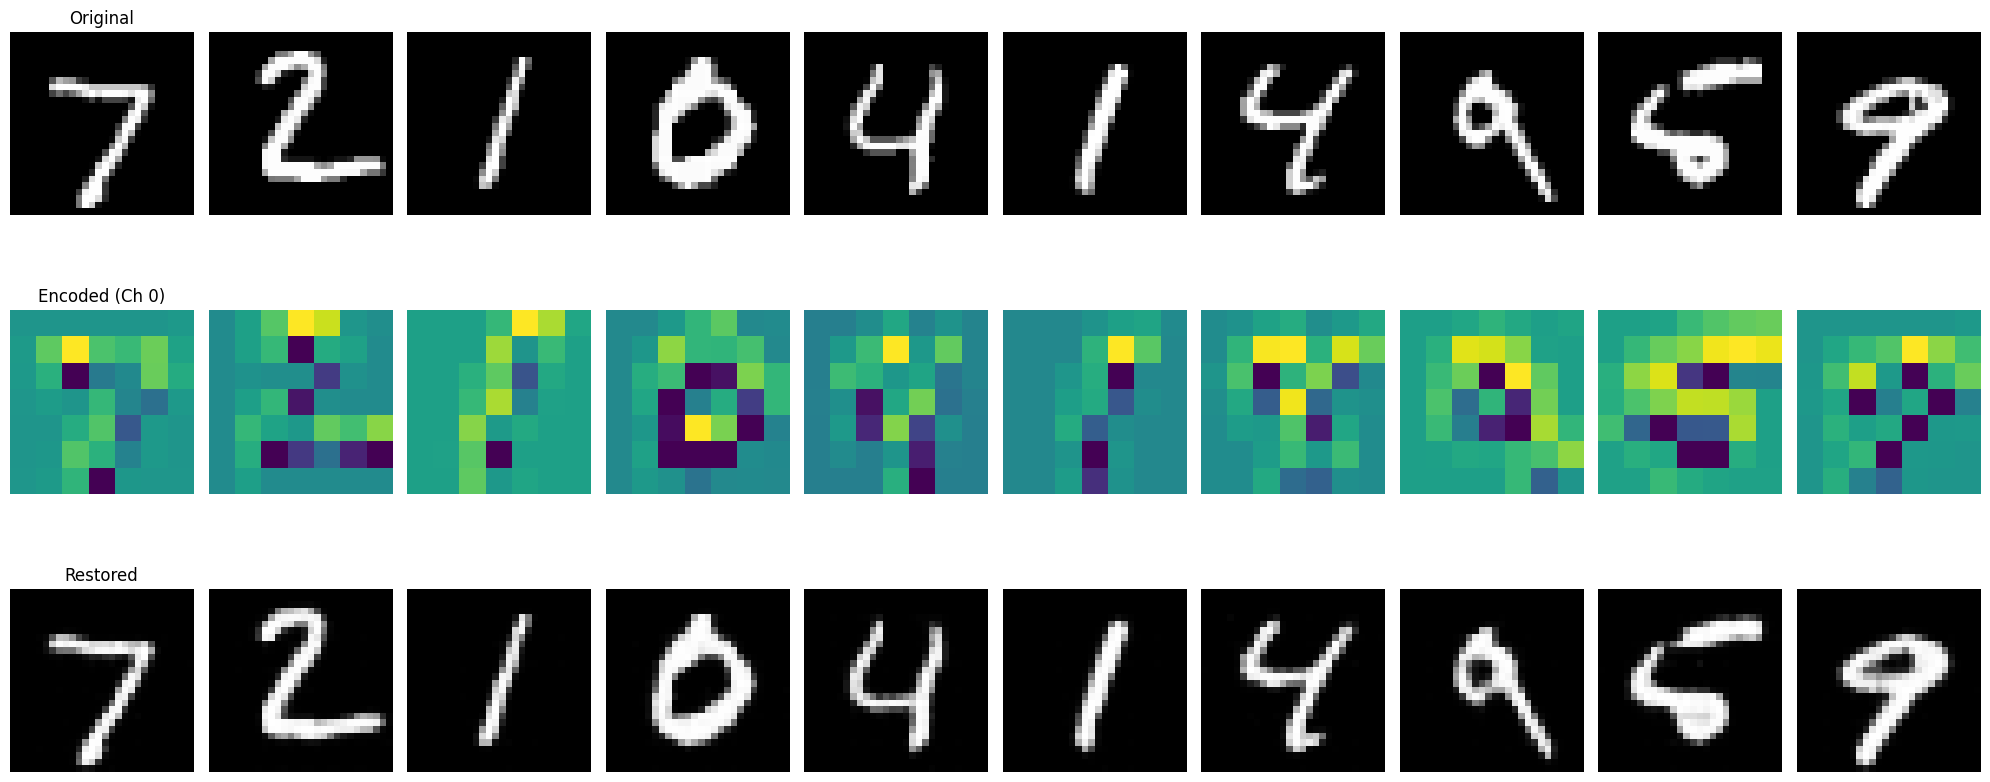

In [23]:
# import matplotlib.pyplot as plt
# import numpy as np

# ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞ÏóêÏÑú Ïù¥ÎØ∏ÏßÄ Í∞ÄÏ†∏Ïò§Í∏∞
images, labels = next(iter(testloader))
images = images[:10] # Ï≤òÏùå 10Í∞ú Ïù¥ÎØ∏ÏßÄÎßå ÏÇ¨Ïö©
# images = images.to(device) # GPU ÏÇ¨Ïö© Ïãú Ï£ºÏÑù Ìï¥Ï†ú

# CNN Ïò§ÌÜ†Ïù∏ÏΩîÎçî Î™®Îç∏ (model2) ÏÇ¨Ïö©
model2.eval() # ÌèâÍ∞Ä Î™®ÎìúÎ°ú ÏÑ§Ï†ï (ÎìúÎ°≠ÏïÑÏõÉ Îì± ÎπÑÌôúÏÑ±Ìôî)

with torch.no_grad(): # Í∏∞Ïö∏Í∏∞ Í≥ÑÏÇ∞ ÎπÑÌôúÏÑ±Ìôî (Î©îÎ™®Î¶¨ Ï†àÏïΩ, ÏÜçÎèÑ Ìñ•ÏÉÅ)
    # Ïù∏ÏΩîÎî©
    encoded_images = model1.encoder(images)
    # ÎîîÏΩîÎî©
    restored_images = model1.decoder(encoded_images)

# ÏãúÍ∞ÅÌôî (ÏõêÎ≥∏ - Ïù∏ÏΩîÎî© Í≤∞Í≥º - Î≥µÏõê Í≤∞Í≥º)
n_imgs = 10
plt.figure(figsize=(20, 9)) # Í∑∏Î¶º ÌÅ¨Í∏∞ ÏÑ§Ï†ï (ÏÑ∏ Ï§ÑÏù¥ÎØÄÎ°ú ÎÜíÏù¥ Ï¶ùÍ∞Ä)

for i in range(n_imgs):
    # ÏõêÎ≥∏ Ïù¥ÎØ∏ÏßÄ (Ï≤´ Î≤àÏß∏ Ï§Ñ)
    ax = plt.subplot(3, n_imgs, i + 1)
    # C, H, W -> H, W, C ÏàúÏÑúÎ°ú Î≥ÄÍ≤Ω (Matplotlib ÏãúÍ∞ÅÌôîÏö©)
    plt.imshow(np.transpose(images[i].numpy(), (1, 2, 0)).squeeze(), cmap='gray')
    ax.set_title('Original' if i == 0 else '') # Ï≤´ Î≤àÏß∏ Ïù¥ÎØ∏ÏßÄÏóêÎßå Ï†úÎ™© ÌëúÏãú
    plt.axis('off') # Ï∂ï Ïà®Í∏∞Í∏∞

    # Ïù∏ÏΩîÎî©Îêú Í≤∞Í≥º (Îëê Î≤àÏß∏ Ï§Ñ) - Ïó¨Í∏∞ÏÑúÎäî Ï≤´ Î≤àÏß∏ Ï±ÑÎÑêÎßå ÏãúÍ∞ÅÌôî
    ax = plt.subplot(3, n_imgs, i + 1 + n_imgs)
    # Ïù∏ÏΩîÎî©Îêú Í≤∞Í≥º: (channels, height, width). ÏãúÍ∞ÅÌôîÎ•º ÏúÑÌï¥ (height, width) ÌòïÌÉúÎ°ú Î≥ÄÌôò.
    # encoded_images[i, 0, :, :]Îäî iÎ≤àÏß∏ Ïù¥ÎØ∏ÏßÄÏùò 0Î≤àÏß∏ Ï±ÑÎÑê (7x7)
    plt.imshow(encoded_images[i, 0, :, :].cpu().numpy(), cmap='viridis') # Ïù∏ÏΩîÎî©Îêú ÌäπÏßï ÏãúÍ∞ÅÌôî (Ïª¨Îü¨Îßµ Î≥ÄÍ≤Ω)
    ax.set_title('Encoded (Ch 0)' if i == 0 else '') # Ï≤´ Î≤àÏß∏ Ïù¥ÎØ∏ÏßÄÏóêÎßå Ï†úÎ™© ÌëúÏãú
    plt.axis('off')

    # Î≥µÏõêÎêú Ïù¥ÎØ∏ÏßÄ (ÏÑ∏ Î≤àÏß∏ Ï§Ñ)
    ax = plt.subplot(3, n_imgs, i + 1 + 2 * n_imgs)
    # Î≥µÏõêÎêú Ïù¥ÎØ∏ÏßÄ: (channels, height, width) -> (height, width, channels)
    plt.imshow(np.transpose(restored_images[i].cpu().numpy(), (1, 2, 0)).squeeze(), cmap='gray')
    ax.set_title('Restored' if i == 0 else '') # Ï≤´ Î≤àÏß∏ Ïù¥ÎØ∏ÏßÄÏóêÎßå Ï†úÎ™© ÌëúÏãú
    plt.axis('off')

plt.tight_layout() # ÏÑúÎ∏åÌîåÎ°Ø Í∞Ñ Í∞ÑÍ≤© Ï°∞Ï†à
plt.show()